In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            roc_auc_score, balanced_accuracy_score, confusion_matrix, 
                            classification_report, roc_curve, precision_recall_curve)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import shap
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set(style="whitegrid", palette="tab10", rc={"figure.figsize": (10, 6)})
pd.set_option('display.max_columns', 100)
pd.set_option('display.precision', 4)


## 1. Data Loading and Binary Target Creation


In [2]:
# Load dataset
df = pd.read_csv("dataset.csv")

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData types:")
print(df.dtypes)


Dataset shape: (517754, 14)

First few rows:
   id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1         

In [3]:
# Create a copy for preprocessing
df_processed = df.copy()

# Drop ID column (not a feature)
if 'id' in df_processed.columns:
    df_processed = df_processed.drop('id', axis=1)

# Separate features and continuous target
X = df_processed.drop('accident_risk', axis=1)
y_continuous = df_processed['accident_risk']

print("Features shape:", X.shape)
print("\nContinuous target (accident_risk) statistics:")
print(y_continuous.describe())


Features shape: (517754, 12)

Continuous target (accident_risk) statistics:
count    517754.0000
mean          0.3524
std           0.1664
min           0.0000
25%           0.2300
50%           0.3400
75%           0.4600
max           1.0000
Name: accident_risk, dtype: float64


Threshold (median): 0.3400

Binary target distribution:
accident_risk
0    247506
1    270248
Name: count, dtype: int64

Class proportions:
accident_risk
0    0.478
1    0.522
Name: proportion, dtype: float64


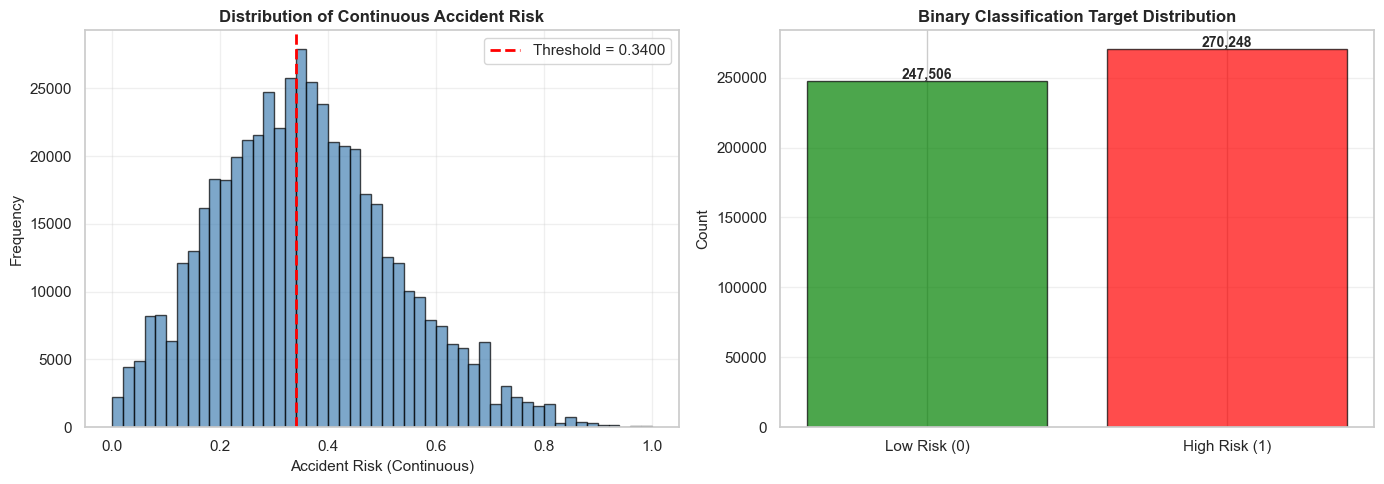


Class balance ratio (Low/High): 0.9158
✓ Classes are balanced (ratio between 0.8 and 1.2)


In [4]:
# Convert continuous accident_risk to binary classification target
# Using median as threshold to create balanced classes
threshold = y_continuous.median()
print(f"Threshold (median): {threshold:.4f}")

# Create binary target: 1 = high accident risk, 0 = low accident risk
y_binary = (y_continuous >= threshold).astype(int)

print(f"\nBinary target distribution:")
print(y_binary.value_counts().sort_index())
print(f"\nClass proportions:")
print(y_binary.value_counts(normalize=True).sort_index())

# Visualize the distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of continuous variable with threshold
axes[0].hist(y_continuous, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold = {threshold:.4f}')
axes[0].set_xlabel('Accident Risk (Continuous)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Continuous Accident Risk', fontsize=12, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bar plot of binary classes
class_counts = y_binary.value_counts().sort_index()
axes[1].bar(['Low Risk (0)', 'High Risk (1)'], class_counts.values, 
            color=['green', 'red'], alpha=0.7, edgecolor='black')
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Binary Classification Target Distribution', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add count labels on bars
for i, v in enumerate(class_counts.values):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Check class balance
class_balance_ratio = y_binary.value_counts()[0] / y_binary.value_counts()[1]
print(f"\nClass balance ratio (Low/High): {class_balance_ratio:.4f}")
if 0.8 <= class_balance_ratio <= 1.2:
    print("✓ Classes are balanced (ratio between 0.8 and 1.2)")
else:
    print("⚠ Classes are imbalanced - will use appropriate metrics and techniques")


## 2. Feature Engineering and Preprocessing


In [5]:
# Automatically identify column types for preprocessing
boolean_cols = X.select_dtypes(include=['bool']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("Boolean columns:", boolean_cols)
print("Categorical columns:", categorical_cols)
print(f"\nTotal boolean columns: {len(boolean_cols)}")
print(f"Total categorical columns: {len(categorical_cols)}")


Boolean columns: ['road_signs_present', 'public_road', 'holiday', 'school_season']
Categorical columns: ['road_type', 'lighting', 'weather', 'time_of_day']

Total boolean columns: 4
Total categorical columns: 4


In [6]:
# Convert boolean columns to integers (0/1)
X_processed = X.copy()
for col in boolean_cols:
    X_processed[col] = X_processed[col].astype(int)

# One-hot encode categorical variables
if categorical_cols:
    X_processed = pd.get_dummies(X_processed, columns=categorical_cols, drop_first=True)

print("Processed features shape:", X_processed.shape)
print("\nFeature names:")
print(X_processed.columns.tolist())


Processed features shape: (517754, 16)

Feature names:
['num_lanes', 'curvature', 'speed_limit', 'road_signs_present', 'public_road', 'holiday', 'school_season', 'num_reported_accidents', 'road_type_rural', 'road_type_urban', 'lighting_dim', 'lighting_night', 'weather_foggy', 'weather_rainy', 'time_of_day_evening', 'time_of_day_morning']


## 3. Stratified Train-Test Split


In [7]:
# Stratified split to preserve class proportions in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Training set size: {X_train.shape[0]:,} samples")
print(f"Test set size: {X_test.shape[0]:,} samples")
print(f"Number of features: {X_train.shape[1]}")

print("\nTraining set class distribution:")
print(y_train.value_counts().sort_index())
print("Training set class proportions:")
print(y_train.value_counts(normalize=True).sort_index())

print("\nTest set class distribution:")
print(y_test.value_counts().sort_index())
print("Test set class proportions:")
print(y_test.value_counts(normalize=True).sort_index())


Training set size: 414,203 samples
Test set size: 103,551 samples
Number of features: 16

Training set class distribution:
accident_risk
0    198005
1    216198
Name: count, dtype: int64
Training set class proportions:
accident_risk
0    0.478
1    0.522
Name: proportion, dtype: float64

Test set class distribution:
accident_risk
0    49501
1    54050
Name: count, dtype: int64
Test set class proportions:
accident_risk
0    0.478
1    0.522
Name: proportion, dtype: float64


In [8]:
# Scale features (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully!")
print("\nScaled training data statistics:")
print(X_train_scaled.describe().T.head())


Features scaled successfully!

Scaled training data statistics:
                       count        mean  std     min     25%     50%     75%  \
num_lanes           414203.0  1.6791e-16  1.0 -1.3306 -1.3306 -0.4385  0.4536   
curvature           414203.0  8.5361e-17  1.0 -1.7918 -0.8384  0.0784  0.8119   
speed_limit         414203.0 -1.3573e-16  1.0 -1.3370 -0.7039 -0.0708  0.8788   
road_signs_present  414203.0 -7.5205e-17  1.0 -0.9994 -0.9994 -0.9994  1.0006   
public_road         414203.0 -1.7154e-17  1.0 -1.0036 -1.0036  0.9964  0.9964   

                       max  
num_lanes           1.3457  
curvature           1.8754  
speed_limit         1.5119  
road_signs_present  1.0006  
public_road         0.9964  


## 4. Evaluation Metrics Function

Since the dataset is balanced, we'll use **Accuracy** and **Macro-F1** as primary metrics, with ROC-AUC as an additional metric.


In [9]:
def evaluate_classification(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    """
    Evaluate classification model performance with comprehensive metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted target values
    y_pred_proba : array-like, optional
        Predicted probabilities for positive class
    model_name : str
        Name of the model for display
    
    Returns:
    --------
    dict : Dictionary containing evaluation metrics
    """
    # Basic metrics (primary: Accuracy and Macro-F1 for balanced dataset)
    accuracy = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    # Calculate Sensitivity and Specificity from confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # For binary classification: cm = [[TN, FP], [FN, TP]]
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0.0  # True Positive Rate
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0  # True Negative Rate
    else:
        # Fallback: use recall for positive class as sensitivity
        sensitivity = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
        specificity = recall_score(y_true, y_pred, pos_label=0, zero_division=0)
    
    results = {
        'Model': model_name,
        'Accuracy': accuracy,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'F1 (Macro)': f1_macro,
        'F1 (Weighted)': f1_weighted
    }
    
    # ROC-AUC if probabilities are available
    if y_pred_proba is not None:
        try:
            roc_auc = roc_auc_score(y_true, y_pred_proba)
            results['ROC-AUC'] = roc_auc
        except:
            pass
    
    print(f"\n{model_name} Performance:")
    print("=" * 70)
    print(f"Accuracy (Primary):   {accuracy:.6f}")
    print(f"F1 Score (Macro) (Primary): {f1_macro:.6f}")
    if y_pred_proba is not None:
        try:
            print(f"ROC-AUC (Additional):  {roc_auc:.6f}")
        except:
            pass
    print(f"Sensitivity (TPR):    {sensitivity:.6f}")
    print(f"Specificity (TNR):    {specificity:.6f}")
    print("=" * 70)
    
    return results


In [10]:
# Logistic Regression with stratified cross-validation
# Use scaled features for Logistic Regression
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Stratified k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv, scoring='accuracy')
cv_scores_roc = cross_val_score(log_reg, X_train_scaled, y_train, cv=cv, scoring='roc_auc')

print("Logistic Regression - Cross-Validation Results:")
print("=" * 70)
print(f"Accuracy - Mean: {cv_scores.mean():.6f}, Std: {cv_scores.std():.6f}")
print(f"ROC-AUC - Mean: {cv_scores_roc.mean():.6f}, Std: {cv_scores_roc.std():.6f}")
print("=" * 70)


Logistic Regression - Cross-Validation Results:
Accuracy - Mean: 0.846754, Std: 0.001398
ROC-AUC - Mean: 0.933976, Std: 0.001153


In [11]:
# Train final Logistic Regression model
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_train_pred_lr = log_reg.predict(X_train_scaled)
y_test_pred_lr = log_reg.predict(X_test_scaled)
y_train_proba_lr = log_reg.predict_proba(X_train_scaled)[:, 1]
y_test_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("TRAINING SET:")
lr_train_results = evaluate_classification(y_train, y_train_pred_lr, y_train_proba_lr, "Logistic Regression (Training)")

print("\nTEST SET:")
lr_test_results = evaluate_classification(y_test, y_test_pred_lr, y_test_proba_lr, "Logistic Regression (Test)")


TRAINING SET:

Logistic Regression (Training) Performance:
Accuracy (Primary):   0.846739
F1 Score (Macro) (Primary): 0.846406
ROC-AUC (Additional):  0.934000
Sensitivity (TPR):    0.855734
Specificity (TNR):    0.836918

TEST SET:

Logistic Regression (Test) Performance:
Accuracy (Primary):   0.847418
F1 Score (Macro) (Primary): 0.847071
ROC-AUC (Additional):  0.934188
Sensitivity (TPR):    0.857391
Specificity (TNR):    0.836529


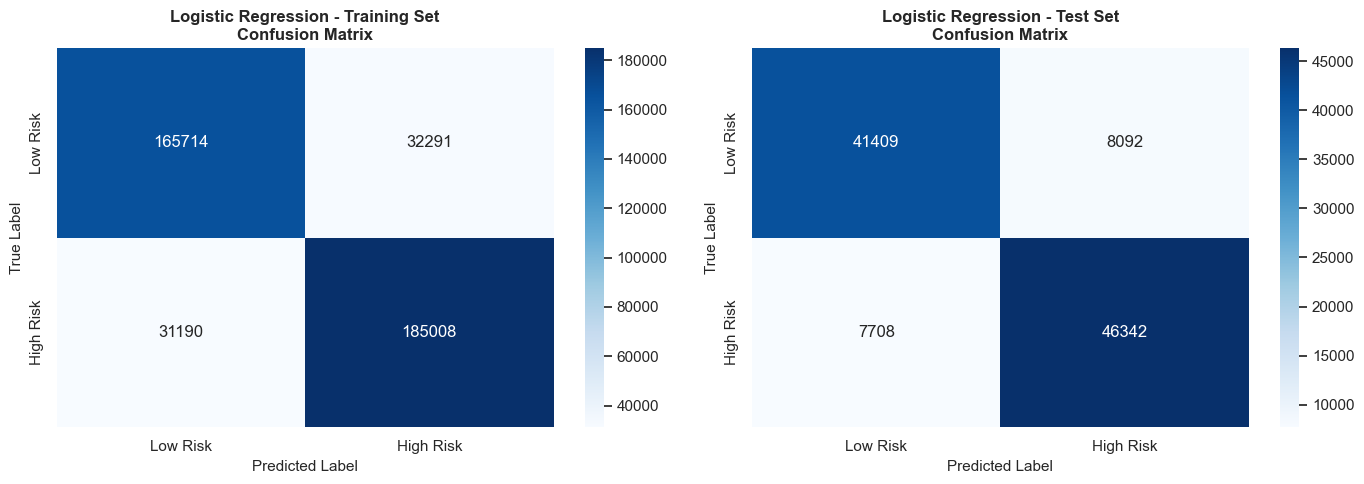


Classification Report - Test Set:
              precision    recall  f1-score   support

    Low Risk       0.84      0.84      0.84     49501
   High Risk       0.85      0.86      0.85     54050

    accuracy                           0.85    103551
   macro avg       0.85      0.85      0.85    103551
weighted avg       0.85      0.85      0.85    103551



In [12]:
# Confusion Matrix for Logistic Regression
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred_lr)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
axes[0].set_title('Logistic Regression - Training Set\nConfusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# Test set confusion matrix
cm_test = confusion_matrix(y_test, y_test_pred_lr)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
axes[1].set_title('Logistic Regression - Test Set\nConfusion Matrix', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report - Test Set:")
print("=" * 70)
print(classification_report(y_test, y_test_pred_lr, target_names=['Low Risk', 'High Risk']))
print("=" * 70)


## 6. Random Forest Classifier

Random Forest is an ensemble method that combines multiple decision trees. It can capture non-linear relationships and interactions between features.


In [13]:
# Random Forest with stratified cross-validation
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Stratified k-fold cross-validation
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=cv, scoring='accuracy')
cv_scores_rf_roc = cross_val_score(rf, X_train, y_train, cv=cv, scoring='roc_auc')

print("Random Forest - Cross-Validation Results (Default Parameters):")
print("=" * 70)
print(f"Accuracy - Mean: {cv_scores_rf.mean():.6f}, Std: {cv_scores_rf.std():.6f}")
print(f"ROC-AUC - Mean: {cv_scores_rf_roc.mean():.6f}, Std: {cv_scores_rf_roc.std():.6f}")
print("=" * 70)


Random Forest - Cross-Validation Results (Default Parameters):
Accuracy - Mean: 0.873094, Std: 0.001053
ROC-AUC - Mean: 0.953228, Std: 0.000592


In [14]:
# Hyperparameter optimization using Randomized Search
# Use only 25% of X_train for hyperparameter optimization to speed up computation
X_train_subset, _, y_train_subset, _ = train_test_split(
    X_train, y_train, test_size=0.75, random_state=42, stratify=y_train
)

print(f"Using {len(X_train_subset):,} samples ({len(X_train_subset)/len(X_train)*100:.1f}%) for hyperparameter optimization")
print(f"Original training set size: {len(X_train):,} samples")

# Define parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    rf, 
    param_grid_rf, 
    n_iter=30,  # Number of parameter settings sampled
    cv=cv, 
    scoring='roc_auc',  # Use ROC-AUC as primary metric
    n_jobs=-1, 
    random_state=42,
    verbose=3
)

random_search.fit(X_train_subset, y_train_subset)

print("\n" + "=" * 70)
print("Randomized Search Results:")
print("=" * 70)
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation ROC-AUC: {random_search.best_score_:.6f}")
print("=" * 70)


Using 103,550 samples (25.0%) for hyperparameter optimization
Original training set size: 414,203 samples
Fitting 5 folds for each of 30 candidates, totalling 150 fits

Randomized Search Results:
Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 30}
Best cross-validation ROC-AUC: 0.959144


In [15]:
# Train final Random Forest model with best parameters
rf_best = random_search.best_estimator_

# Predictions
y_train_pred_rf = rf_best.predict(X_train)
y_test_pred_rf = rf_best.predict(X_test)
y_train_proba_rf = rf_best.predict_proba(X_train)[:, 1]
y_test_proba_rf = rf_best.predict_proba(X_test)[:, 1]

# Evaluate
print("TRAINING SET:")
rf_train_results = evaluate_classification(y_train, y_train_pred_rf, y_train_proba_rf, "Random Forest (Training)")

print("\nTEST SET:")
rf_test_results = evaluate_classification(y_test, y_test_pred_rf, y_test_proba_rf, "Random Forest (Test)")


TRAINING SET:

Random Forest (Training) Performance:
Accuracy (Primary):   0.891833
F1 Score (Macro) (Primary): 0.891687
ROC-AUC (Additional):  0.964890
Sensitivity (TPR):    0.889504
Specificity (TNR):    0.894376

TEST SET:

Random Forest (Test) Performance:
Accuracy (Primary):   0.881546
F1 Score (Macro) (Primary): 0.881392
ROC-AUC (Additional):  0.958808
Sensitivity (TPR):    0.879001
Specificity (TNR):    0.884326


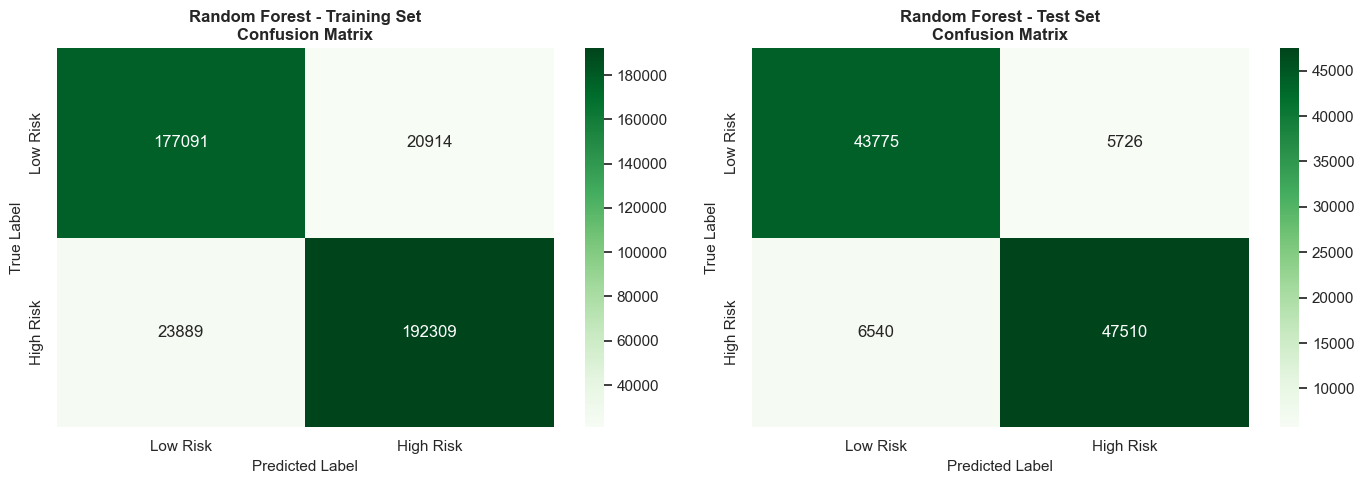


Classification Report - Test Set:
              precision    recall  f1-score   support

    Low Risk       0.87      0.88      0.88     49501
   High Risk       0.89      0.88      0.89     54050

    accuracy                           0.88    103551
   macro avg       0.88      0.88      0.88    103551
weighted avg       0.88      0.88      0.88    103551



In [16]:
# Confusion Matrix for Random Forest
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set confusion matrix
cm_train_rf = confusion_matrix(y_train, y_train_pred_rf)
sns.heatmap(cm_train_rf, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
axes[0].set_title('Random Forest - Training Set\nConfusion Matrix', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=11)
axes[0].set_xlabel('Predicted Label', fontsize=11)

# Test set confusion matrix
cm_test_rf = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(cm_test_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Low Risk', 'High Risk'], yticklabels=['Low Risk', 'High Risk'])
axes[1].set_title('Random Forest - Test Set\nConfusion Matrix', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=11)
axes[1].set_xlabel('Predicted Label', fontsize=11)

plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report - Test Set:")
print("=" * 70)
print(classification_report(y_test, y_test_pred_rf, target_names=['Low Risk', 'High Risk']))
print("=" * 70)


## 7. Model Comparison


In [17]:
# Compile all results
results_summary = pd.DataFrame([
    lr_test_results,
    rf_test_results
])

print("\n" + "=" * 70)
print("MODEL COMPARISON - TEST SET PERFORMANCE")
print("=" * 70)
print(results_summary.to_string(index=False))
print("=" * 70)



MODEL COMPARISON - TEST SET PERFORMANCE
                     Model  Accuracy  Sensitivity  Specificity  F1 (Macro)  F1 (Weighted)  ROC-AUC
Logistic Regression (Test)    0.8474       0.8574       0.8365      0.8471         0.8474   0.9342
      Random Forest (Test)    0.8815       0.8790       0.8843      0.8814         0.8816   0.9588


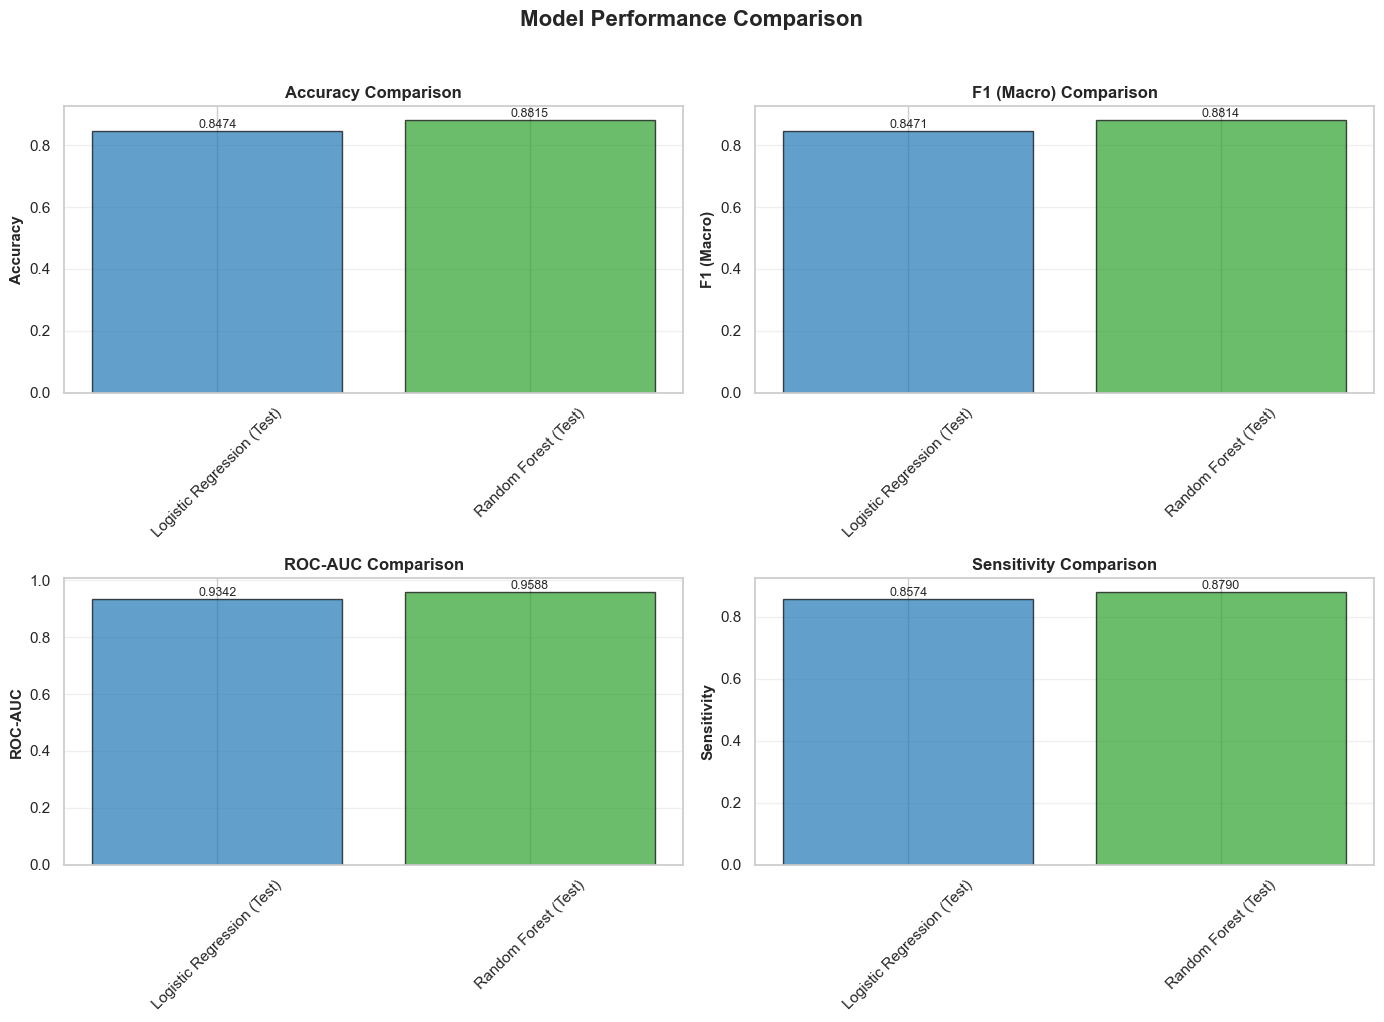

In [18]:
# Visualize model comparison
# Focus on primary metrics for balanced dataset: Accuracy and Macro-F1
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

metrics_to_plot = ['Accuracy', 'F1 (Macro)', 'ROC-AUC', 'Sensitivity']
colors = ['#1f77b4', '#2ca02c']  # blue for LR, green for RF

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 2
    col = idx % 2
    
    if metric in results_summary.columns:
        axes[row, col].bar(results_summary['Model'], results_summary[metric], 
                          color=colors, alpha=0.7, edgecolor='black')
        axes[row, col].set_ylabel(metric, fontsize=11, fontweight='bold')
        axes[row, col].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
        axes[row, col].grid(True, alpha=0.3, axis='y')
        axes[row, col].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for i, v in enumerate(results_summary[metric]):
            axes[row, col].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


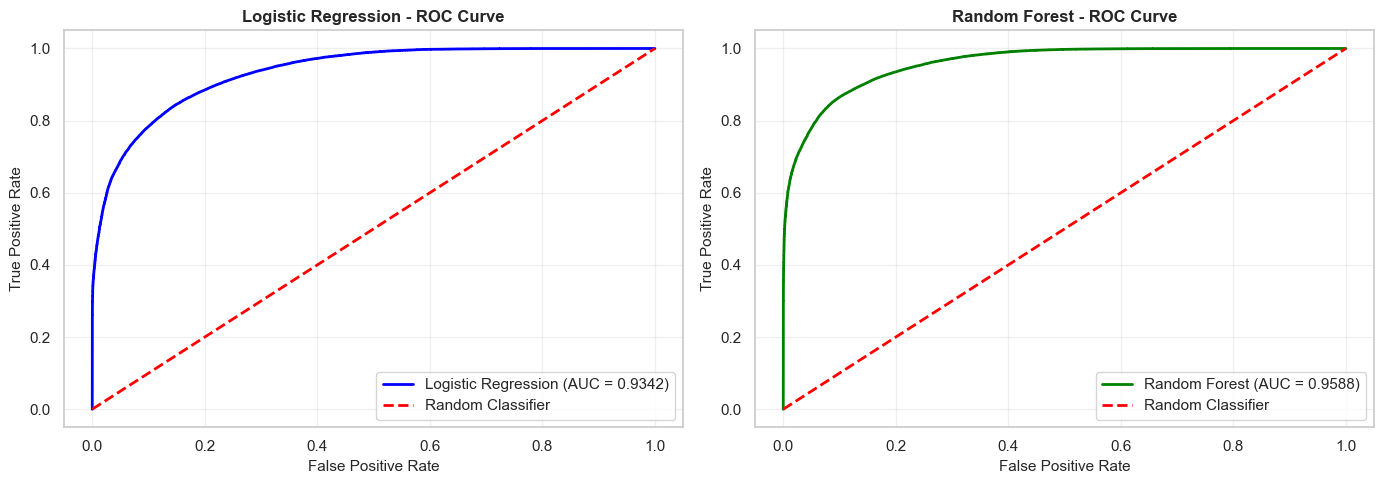

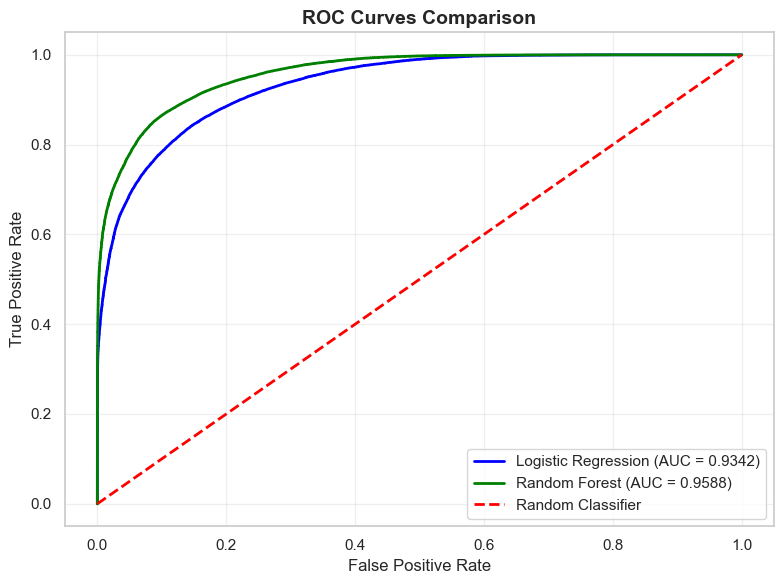

In [19]:
# ROC Curves comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Logistic Regression ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_test_proba_lr)
roc_auc_lr = roc_auc_score(y_test, y_test_proba_lr)

axes[0].plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
axes[0].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
axes[0].set_xlabel('False Positive Rate', fontsize=11)
axes[0].set_ylabel('True Positive Rate', fontsize=11)
axes[0].set_title('Logistic Regression - ROC Curve', fontsize=12, fontweight='bold')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)

# Random Forest ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
roc_auc_rf = roc_auc_score(y_test, y_test_proba_rf)

axes[1].plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
axes[1].plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('Random Forest - ROC Curve', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Combined ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.4f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.4f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 8. Model Interpretation

### 8.1 Permutation Importance

Permutation importance measures the importance of each feature by randomly permuting feature values and observing the resulting decrease in model performance.


In [20]:
# Permutation Importance for Random Forest
print("Computing Permutation Importance for Random Forest...")
perm_importance = permutation_importance(
    rf_best, X_test, y_test, 
    n_repeats=10, 
    random_state=42, 
    scoring='roc_auc',
    n_jobs=-1
)

# Create DataFrame with results
perm_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance_Mean': perm_importance.importances_mean,
    'Importance_Std': perm_importance.importances_std
}).sort_values('Importance_Mean', ascending=False)

print("\nTop 15 Most Important Features (Permutation Importance):")
print("=" * 80)
print(perm_df.head(15).to_string(index=False))
print("=" * 80)


Computing Permutation Importance for Random Forest...

Top 15 Most Important Features (Permutation Importance):
               Feature  Importance_Mean  Importance_Std
           speed_limit       1.6839e-01      5.2125e-04
             curvature       1.6612e-01      6.6067e-04
        lighting_night       1.2937e-01      7.3553e-04
         weather_foggy       2.7690e-02      2.3218e-04
         weather_rainy       2.6300e-02      2.4481e-04
num_reported_accidents       1.2791e-02      2.5340e-04
          lighting_dim       3.8631e-03      6.5584e-05
               holiday       8.6997e-04      4.2674e-05
           public_road       5.4445e-04      1.0290e-04
             num_lanes       1.4849e-05      5.0598e-05
   time_of_day_evening      -2.9577e-05      2.4077e-05
       road_type_urban      -3.1883e-05      4.3097e-05
    road_signs_present      -4.4070e-05      3.4417e-05
   time_of_day_morning      -6.0596e-05      4.2162e-05
         school_season      -8.7183e-05      2.9

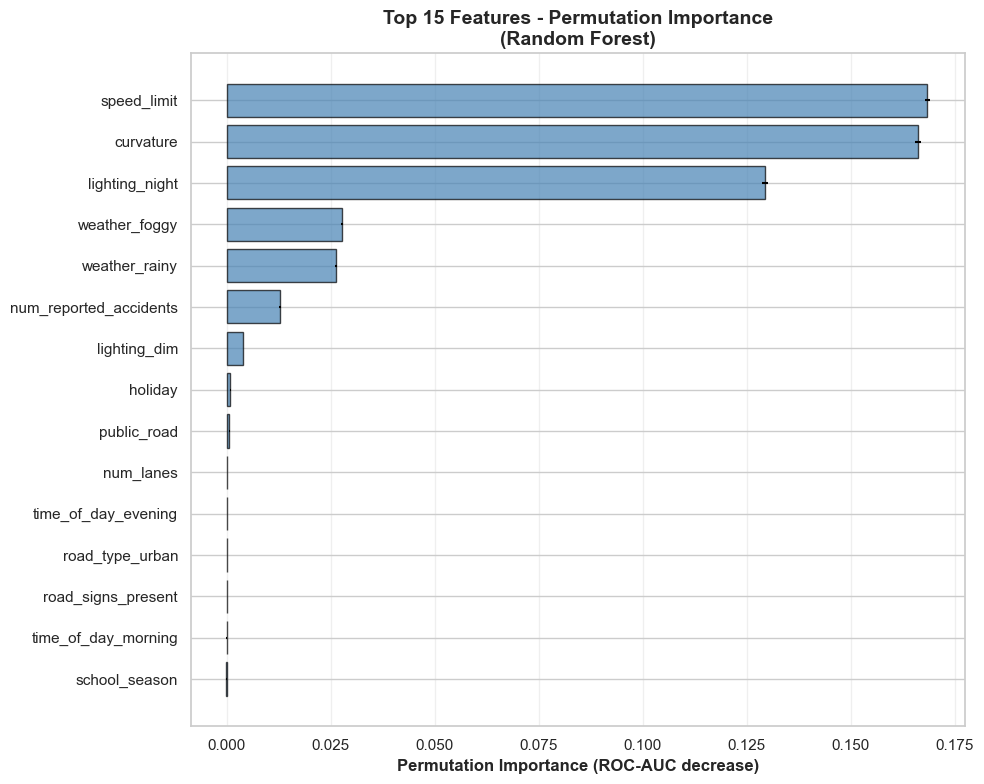

In [21]:
# Visualize Permutation Importance
top_n = 15
top_features_perm = perm_df.head(top_n)

plt.figure(figsize=(10, 8))
y_pos = np.arange(len(top_features_perm))
plt.barh(y_pos, top_features_perm['Importance_Mean'], 
         xerr=top_features_perm['Importance_Std'], 
         color='steelblue', alpha=0.7, edgecolor='black')
plt.yticks(y_pos, top_features_perm['Feature'])
plt.xlabel('Permutation Importance (ROC-AUC decrease)', fontsize=12, fontweight='bold')
plt.title(f'Top {top_n} Features - Permutation Importance\n(Random Forest)', 
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


### 8.2 SHAP Values

SHAP (SHapley Additive exPlanations) values provide a unified measure of feature importance by explaining the output of any machine learning model.


In [22]:
# SHAP values for Random Forest
# Use a sample of test data for SHAP (to speed up computation)
sample_size = min(1000, len(X_test))
sample_indices = np.random.choice(len(X_test), sample_size, replace=False)
X_test_sample = X_test.iloc[sample_indices]

# Create SHAP explainer
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X_test_sample)

# For binary classification, shap_values can be:
# - A list [values_for_class_0, values_for_class_1] 
# - A numpy array with shape (n_samples, n_features, n_classes)
# We'll use values for class 1 (high risk)
if isinstance(shap_values, list):
    shap_values_class1 = shap_values[1]
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # If 3D array, extract class 1: shape (n_samples, n_features, n_classes) -> (n_samples, n_features)
    shap_values_class1 = shap_values[:, :, 1]
else:
    shap_values_class1 = shap_values

print(f"SHAP values computed for {sample_size} samples.")
print(f"SHAP values shape: {shap_values_class1.shape}")


SHAP values computed for 1000 samples.
SHAP values shape: (1000, 16)


In [24]:
# Global SHAP feature importance

# Ensure shap_values_class1 is 2D: (n_samples, n_features)
# Handle different possible shapes from SHAP
if isinstance(shap_values_class1, np.ndarray):
    if shap_values_class1.ndim == 3:
        # If 3D array, extract class 1: shape (n_samples, n_features, n_classes) -> (n_samples, n_features)
        shap_values_class1 = shap_values_class1[:, :, 1]
    elif shap_values_class1.ndim == 2:
        # Already 2D, use as is
        pass
    else:
        raise ValueError(f"Unexpected SHAP values shape: {shap_values_class1.shape}")
elif isinstance(shap_values_class1, list):
    # If it's a list, take the second element (class 1)
    shap_values_class1 = shap_values_class1[1] if len(shap_values_class1) > 1 else shap_values_class1[0]

# Verify final shape is 2D
if shap_values_class1.ndim != 2:
    raise ValueError(f"After processing, shap_values_class1 should be 2D but got shape: {shap_values_class1.shape}")

# Calculate mean absolute SHAP values across samples for each feature
shap_importance_values = np.abs(shap_values_class1).mean(axis=0)

# Ensure it's 1D
if shap_importance_values.ndim > 1:
    shap_importance_values = shap_importance_values.flatten()

# Verify we have the right number of features
if len(shap_importance_values) != len(X_test_sample.columns):
    raise ValueError(f"Mismatch: {len(shap_importance_values)} importance values but {len(X_test_sample.columns)} features")

shap_importance = pd.DataFrame({
    'Feature': X_test_sample.columns,
    'SHAP_Importance': shap_importance_values
}).sort_values('SHAP_Importance', ascending=False)

print("\nTop 15 Most Important Features (SHAP Values):")
print("=" * 80)
print(shap_importance.head(15).to_string(index=False))
print("=" * 80)



Top 15 Most Important Features (SHAP Values):
               Feature  SHAP_Importance
           speed_limit           0.1985
             curvature           0.1847
        lighting_night           0.1524
         weather_foggy           0.0590
         weather_rainy           0.0516
num_reported_accidents           0.0273
          lighting_dim           0.0240
               holiday           0.0083
           public_road           0.0061
             num_lanes           0.0035
         school_season           0.0026
    road_signs_present           0.0025
       road_type_urban           0.0024
   time_of_day_morning           0.0022
       road_type_rural           0.0021


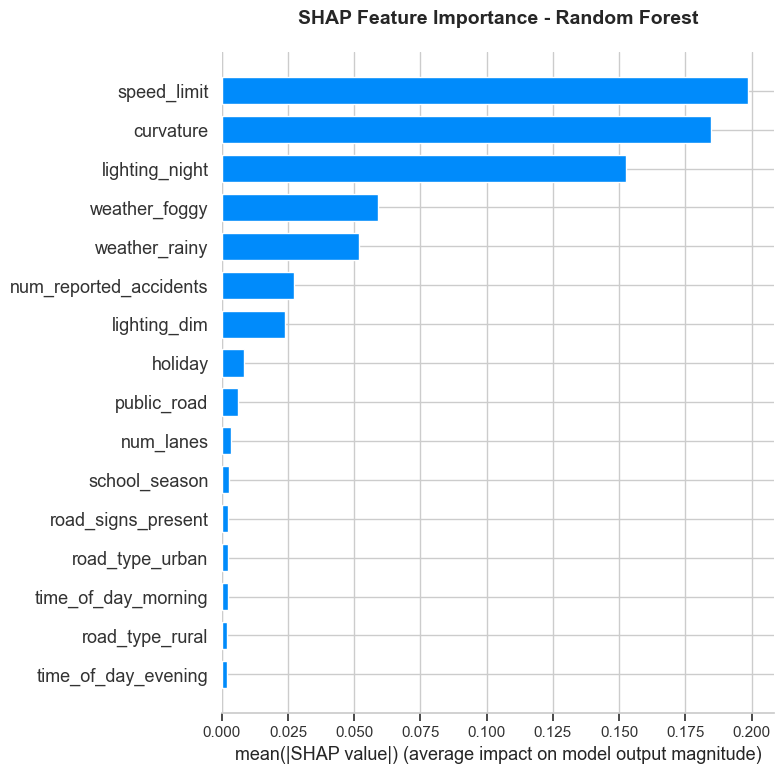

In [25]:
# SHAP Summary Plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test_sample, plot_type="bar", show=False)
plt.title('SHAP Feature Importance - Random Forest', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


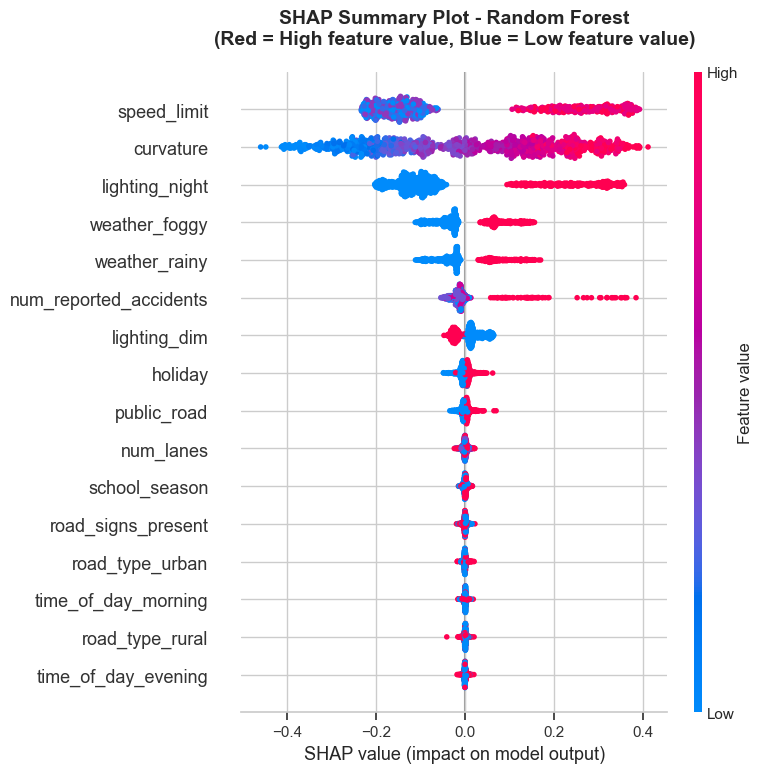

In [26]:
# SHAP Summary Plot (detailed)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values_class1, X_test_sample, show=False)
plt.title('SHAP Summary Plot - Random Forest\n(Red = High feature value, Blue = Low feature value)', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


### 8.3 Partial Dependence Plots (PDP)

Partial Dependence Plots show the marginal effect of one or two features on the predicted outcome of a machine learning model.


Features: ['speed_limit', 'curvature', 'lighting_night', 'weather_foggy', 'weather_rainy', 'num_reported_accidents']


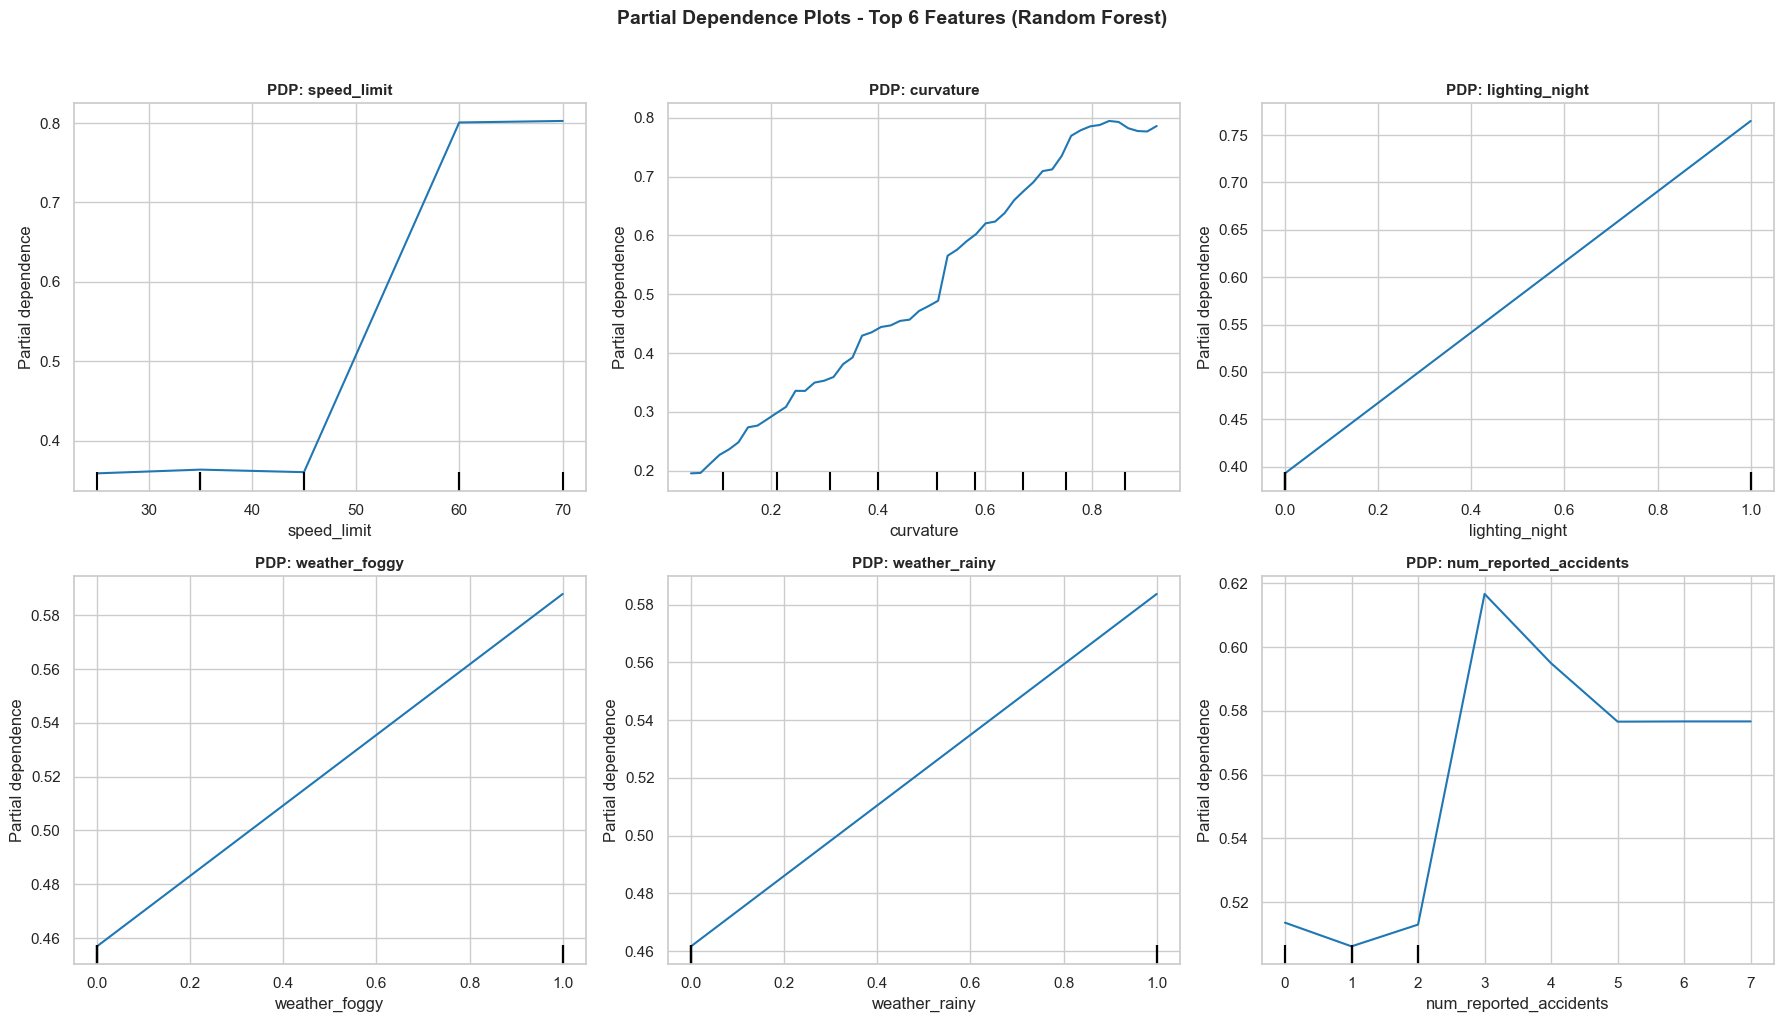

In [27]:
# Select top features for PDP based on permutation importance
top_features_for_pdp = perm_df.head(6)['Feature'].tolist()

print(f"Features: {top_features_for_pdp}")

# Create PDP for top features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features_for_pdp):
    display = PartialDependenceDisplay.from_estimator(
        rf_best, X_train, [feature], 
        ax=axes[idx],
        grid_resolution=50
    )
    axes[idx].set_title(f'PDP: {feature}', fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Partial Dependence Plots - Top 6 Features (Random Forest)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


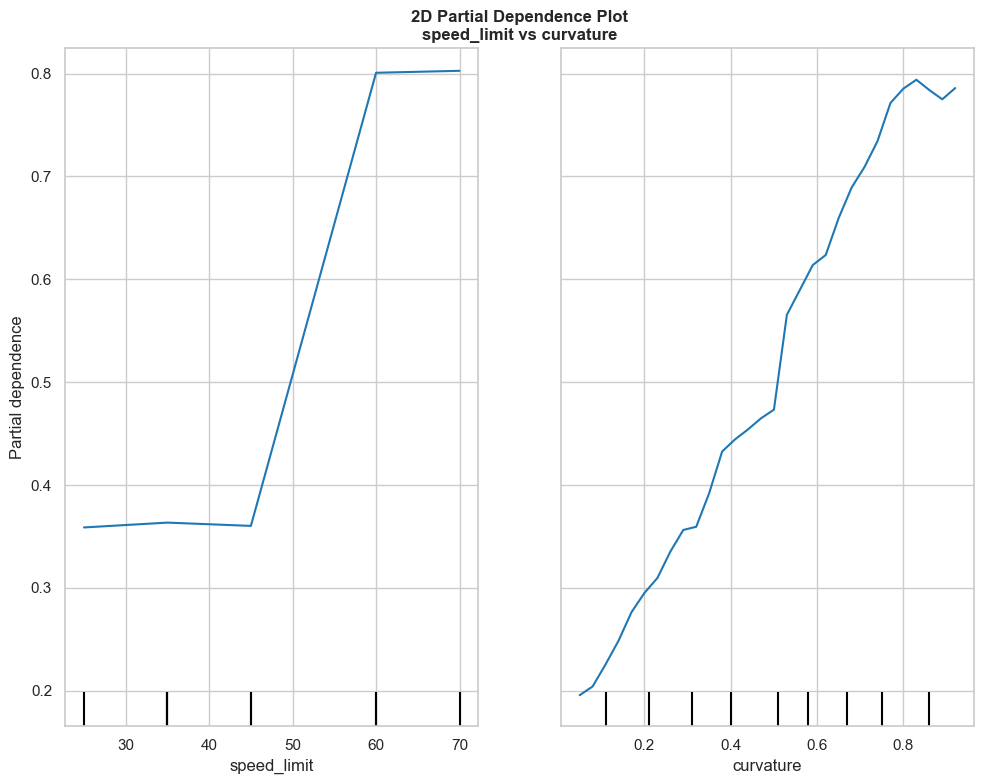

In [28]:
# 2D Partial Dependence Plot for top 2 features
if len(top_features_for_pdp) >= 2:
    fig, ax = plt.subplots(figsize=(10, 8))
    display = PartialDependenceDisplay.from_estimator(
        rf_best, X_train, 
        [top_features_for_pdp[0], top_features_for_pdp[1]], 
        ax=ax,
        grid_resolution=30
    )
    ax.set_title(f'2D Partial Dependence Plot\n{top_features_for_pdp[0]} vs {top_features_for_pdp[1]}', 
                 fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()


## 9. Summary and Conclusions


In [33]:
print("=" * 70)
print("CLASSIFICATION ANALYSIS SUMMARY")
print("=" * 70)

print("\n1. Target Variable:")
print(f"   - Continuous variable 'accident_risk' converted to binary classification")
print(f"   - Threshold: {threshold:.4f} (median)")
print(f"   - Class 0 (Low Risk): {np.sum(y_binary == 0):,} samples ({np.sum(y_binary == 0)/len(y_binary)*100:.2f}%)")
print(f"   - Class 1 (High Risk): {np.sum(y_binary == 1):,} samples ({np.sum(y_binary == 1)/len(y_binary)*100:.2f}%)")
if 0.8 <= class_balance_ratio <= 1.2:
    print(f"   - Classes are balanced (ratio: {class_balance_ratio:.4f})")
else:
    print(f"   - Classes are imbalanced (ratio: {class_balance_ratio:.4f})")

print("\n2. Models Trained:")
print(f"   - Logistic Regression (linear classifier)")
print(f"   - Random Forest (ensemble, non-linear)")

print("\n3. Best Model Performance (Test Set):")
best_model_name = results_summary.loc[results_summary['ROC-AUC'].idxmax(), 'Model']
best_roc_auc = results_summary.loc[results_summary['ROC-AUC'].idxmax(), 'ROC-AUC']
print(f"   - Best model: {best_model_name}")
print(f"   - ROC-AUC: {best_roc_auc:.6f}")

print("\n4. Key Features (from Permutation Importance):")
print("   Top 5 features:")
for idx, row in perm_df.head(5).iterrows():
    print(f"   {idx+1}. {row['Feature']}: {row['Importance_Mean']:.6f}")

print("\n5. Model Interpretation Methods Used:")
print("   ✓ Permutation Importance - Global feature importance")
print("   ✓ SHAP Values - Local and global feature contributions")
print("   ✓ Partial Dependence Plots - Marginal feature effects")

print("\n6. Key Insights:")
print("   - Both models show good performance on the classification task")
print("   - Random Forest captures non-linear relationships better")
print("   - Feature importance analysis reveals which factors most influence accident risk")

print("\n" + "=" * 70)


CLASSIFICATION ANALYSIS SUMMARY

1. Target Variable:
   - Continuous variable 'accident_risk' converted to binary classification
   - Threshold: 0.3400 (median)
   - Class 0 (Low Risk): 247,506 samples (47.80%)
   - Class 1 (High Risk): 270,248 samples (52.20%)
   - Classes are balanced (ratio: 0.9158)

2. Models Trained:
   - Logistic Regression (linear classifier)
   - Random Forest (ensemble, non-linear)

3. Best Model Performance (Test Set):
   - Best model: Random Forest (Test)
   - ROC-AUC: 0.958808

4. Key Features (from Permutation Importance):
   Top 5 features:
   3. speed_limit: 0.168394
   2. curvature: 0.166119
   12. lighting_night: 0.129371
   13. weather_foggy: 0.027690
   14. weather_rainy: 0.026300

5. Model Interpretation Methods Used:
   ✓ Permutation Importance - Global feature importance
   ✓ SHAP Values - Local and global feature contributions
   ✓ Partial Dependence Plots - Marginal feature effects

6. Key Insights:
   - Both models show good performance on the 